# Implementing a Declarative Node using the `ddn.basic.node` Module

In this notebook we demonstrate how to implement a declarative node using the `ddn.basic.node` module. This will allow us to explore the behavior of the node and solve simple bi-level optimization problems. For more sophisticated problems and integrating into large deep learning models use modules in the package `ddn.pytorch` instead.

We consider the problem of minimizing the KL-divergence between the input $x$ and output $y$ subject to the output forming a valid probablility vector (i.e., the elements of $y$ be positive and sum to one). We will assume strictly positive $x$. The problem can be written formally as

$$
\begin{array}{rll}
y =& \text{argmin}_u & - \sum_{i=1}^{n} x_i \log u_i \\
& \text{subject to} & \sum_{i=1}^{n} u_i = 1
\end{array}
$$
where the positivity constraint on $y$ is automatically satisfied by the domain of the log function.

A nice feature of this problem is that we can solve it in closed-form as
$$
y = \frac{1}{\sum_{i=1}^{n} x_i} x.
$$

However, we will only use this for verification and pretend for now that we do not have a closed-form solution. Instead we will make use of the `scipy.optimize` module to solve the problem via an iterative method. Deriving our deep declarative node from the `LinEqConstDeclarativeNode` class, we will need to implement two functions: the `objective` function and the `solve` function (the `constraint` and `gradient` functions are implemented for us).


In [1]:
import numpy as np
import scipy.optimize as opt

import sys
sys.path.append("../")
from ddn.basic.node import *

import warnings
warnings.filterwarnings('ignore')

# create the example node
class MinKLNode(LinEqConstDeclarativeNode):
    def __init__(self, n):
        # Here we establish the linear equality constraint, Au = b. Since we want the sum of the
        # u_i to equal one we set A to be the all-ones row vector and b to be the scalar 1.
        super().__init__(n, n, np.ones((1,n)), np.ones((1,1)))

    def objective(self, x, u):
        return -1.0 * np.dot(x, np.log(u))
        
    def solve(self, x):
        # Solve the constrained optimization problem using scipy's built-in minimize function. Here we
        # initialize the solver at the uniform distribution.
        u0 = np.ones((self.dim_y,)) / self.dim_y
        result = opt.minimize(lambda u: self.objective(x, u), u0,
                              constraints={'type': 'eq', 'fun': lambda u: (np.dot(self.A, u) - self.b)[0]})
        
        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return result.x, None

In [2]:
# test the node
node = MinKLNode(5)
x = np.random.random(5)
print("Input:           {}".format(x))
print("Expected output: {}".format(x / np.sum(x)))

y, _ = node.solve(x)
print("Actual output:   {}".format(y))

Input:           [0.74193998 0.57370219 0.11453098 0.4469884  0.21293766]
Expected output: [0.35497836 0.27448562 0.05479691 0.2138599  0.10187921]
Actual output:   [0.35497539 0.27448363 0.05477828 0.2138605  0.10190221]


We now plot the function and gradient sweeping the first component of the input $x_1$ from 0.1 to 10.0 while holding the other values of $x$ constant.

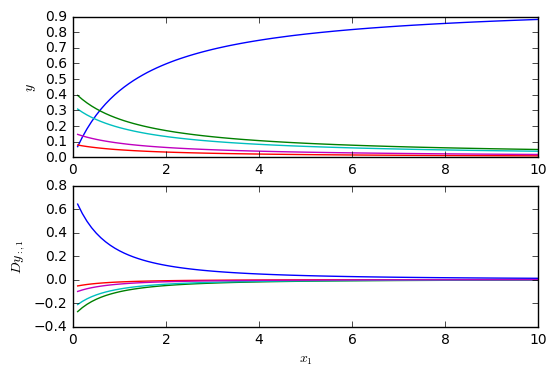

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

x_data = np.linspace(0.1, 10.0, 100)
y_data = []
Dy_data = []
for x[0] in x_data:
    y, _ = node.solve(x)
    y_data.append(y)
    Dy_data.append(node.gradient(x, y)[:,0])
    
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x_data, y_data)
plt.ylabel(r"$y$")

plt.subplot(2, 1, 2)
plt.plot(x_data, Dy_data)
plt.xlabel(r"$x_1$"); plt.ylabel(r"$Dy_{:,1}$")
plt.show()


### Bi-level optimization

Now let's see whether we can use the node within a bi-level optimization problem. We will attempt to learn an input $x$ that results in an output $y$ with smallest norm-squared. Moreover, we will regularize the norm of $x$ to be close to 10. Given our understanding of KL-divergence this should learn a vector $x$ that is a constant multiple of the ones vector (i.e., all elements of $x$ should be the same). Let's see what happens.

Found x = [4.47197341 4.47190757 4.47221775 4.47244731 4.47212795] with norm 10.00
Results in y = [0.19999193 0.19998864 0.20000415 0.20001563 0.19999966]


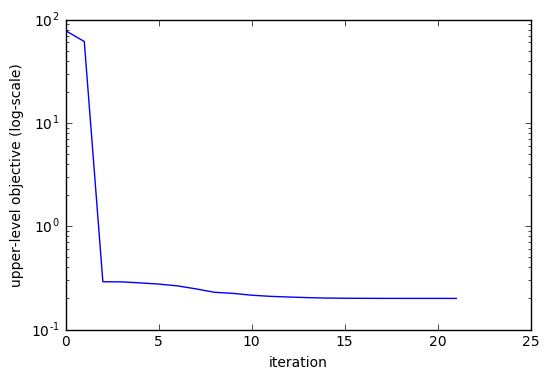

In [4]:
from autograd import grad

# define the upper-level objective
def JofXandY(x, y):
    return np.dot(y, y) + np.power(np.sqrt(np.dot(x, x)) - 10.0, 2.0)

def JofX(x):
    y, ctx = node.solve(x)
    return JofXandY(x, y)

def dJofX(x):
    Jx = grad(JofXandY, 0)
    Jy = grad(JofXandY, 1)
    y, ctx = node.solve(x)
    return Jx(x, y) + np.dot(Jy(x, y), node.gradient(x, y, ctx))

# solve using L-BFGS
x0 = np.random.random(node.dim_x)
history = [JofX(x0)]
result = opt.minimize(JofX, x0, args=(), method='L-BFGS-B', jac=dJofX,
                      options={'maxiter': 100, 'disp': False},
                      bounds=[(1.0e-6, None) for xk in x0],
                      callback=lambda xk : history.append(JofX(xk)))

x = result.x
y, _ = node.solve(x)
print("Found x = {} with norm {:0.2f}".format(x, np.sqrt(np.dot(x, x))))
print("Results in y = {}".format(y))

fig = plt.figure()
plt.semilogy(history)
plt.ylabel("upper-level objective (log-scale)"); plt.xlabel("iteration")
plt.show()